<a href="https://www.kaggle.com/code/mrsalty/eda-milan-air-pollution-2003-2024?scriptVersionId=171518575" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# EDA | Milan air pollution (2003-2024)

<img src="https://www.yesmilano.it/sites/default/files/styles/testata_full/public/itinerario/copertina/6298/23579/posti-da-vedere-fotografare-a-milano-di-notte.jpg?itok=wP9aMJ1Z" width="550">

# EU Regulation

Concentration limits as per [European Environment Agency](https://www.eea.europa.eu/themes/air/urban-air-quality)

| Agent    | Limit |
| -------- | ------- |
| **PM25**  | 25 $µg$/$m^3$    |
| **PM10**  | 50 $µg$/$m^3$     |
| **O3**  | 120 $µg$/$m^3$     |
| **NO2**  | 40 $µg$/$m^3$     |
| **SO2**  | 3 $µg$/$m^3$     |
| **CO**  | 10 $µg$/$m^3$     |
| **C6H6**  | 5 $µg$/$m^3$     |


In [1]:
agent_eu_limits = {
    'PM25':25, 
    'PM10':50,
    'O3':120,
    'NO2':40,
    'SO2':3,
    'CO_8h':10,  
    'C6H6':5  
}

In [2]:
# imports
import csv
import pandas as pd
import numpy as np 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sb 
import warnings
from matplotlib.pyplot import figure

warnings.filterwarnings('ignore')

# Dataset Analysis

In [3]:
df = pd.read_csv('/kaggle/input/milan-air-quality-202024/milan-air-pollution.csv',sep=';',on_bad_lines='skip')
df.head()

,stazione_id,data,inquinante,valore
0,1,2018-01-03,NO2,NaN
1,3,2018-01-03,NO2,103.0
2,3,2018-01-03,CO_8h,1.4
3,4,2018-01-03,NO2,105.0
4,4,2018-01-03,CO_8h,1.1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307847 entries, 0 to 307846
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   stazione_id  307847 non-null  int64  
 1   data         307847 non-null  object 
 2   inquinante   307847 non-null  object 
 3   valore       252985 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 9.4+ MB


In [5]:
df.describe()

,stazione_id,valore
count,307847.000000,252985.000000
mean,4.840047,48.116944
std,2.373487,49.736632
min,1.000000,0.000000
25%,2.000000,2.300000
50%,5.000000,33.000000
75%,7.000000,83.000000
max,9.000000,403.000000


In [6]:
for col in df:
    print(f'{col} unique vals:{df[col].unique()}')

stazione_id unique vals:[1 3 4 5 2 6 7 8 9]
data unique vals:['2018-01-03' '2018-01-04' '2018-01-05' ... '2024-01-04' '2024-01-03'
 '2024-01-02']
inquinante unique vals:['NO2' 'CO_8h' 'C6H6' 'O3' 'SO2' 'PM10' 'PM25']
valore unique vals:[  nan 103.    1.4 ...   8.8   6.9  10.1]


In [7]:
pollution_agents = df['inquinante'].unique()

In [8]:
df['data'] = pd.to_datetime(df['data'], format = '%Y-%m-%d')

In [9]:
# drop null values for 'valore'
df = df.dropna()

Text(0.5, 0, 'year')

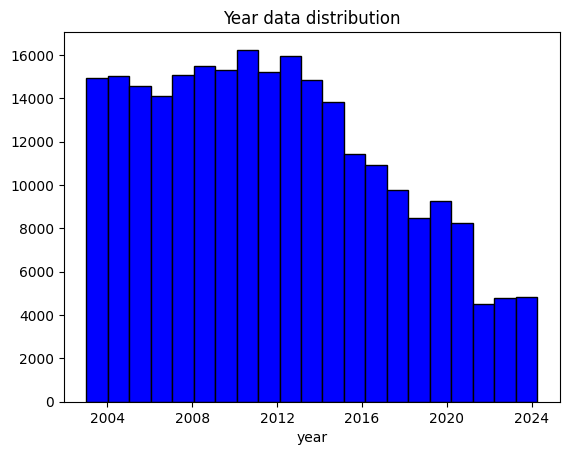

In [10]:
plt.hist(x=df['data'], color = 'blue', edgecolor = 'black', bins = 21)
plt.title('Year data distribution')
plt.xlabel("year")

# Pollution agents timeseries

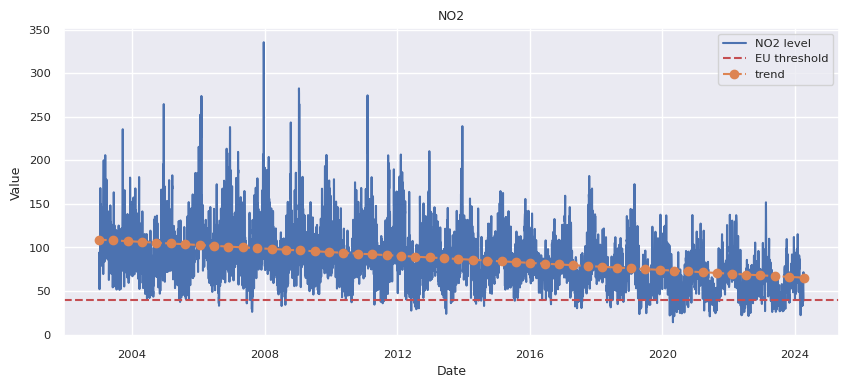

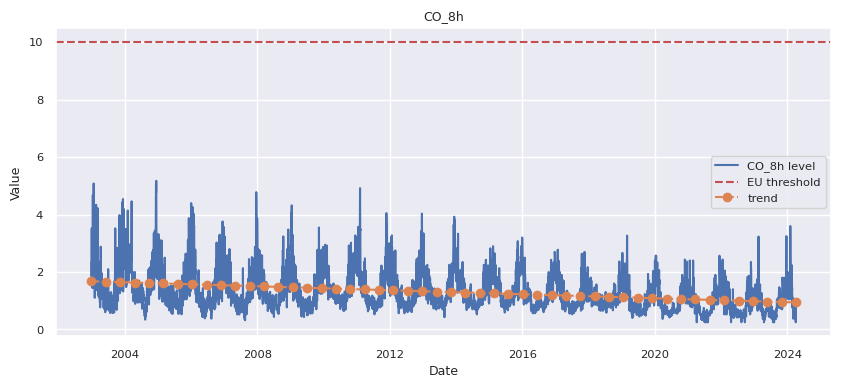

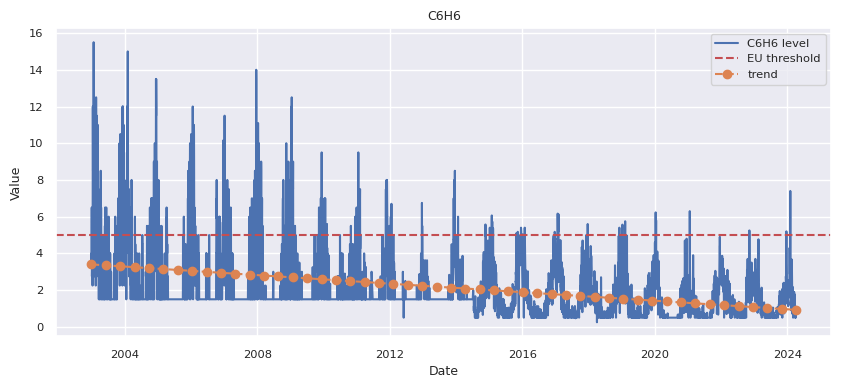

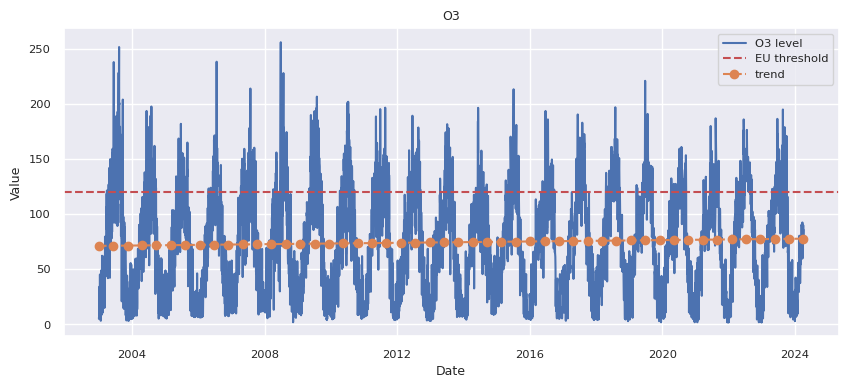

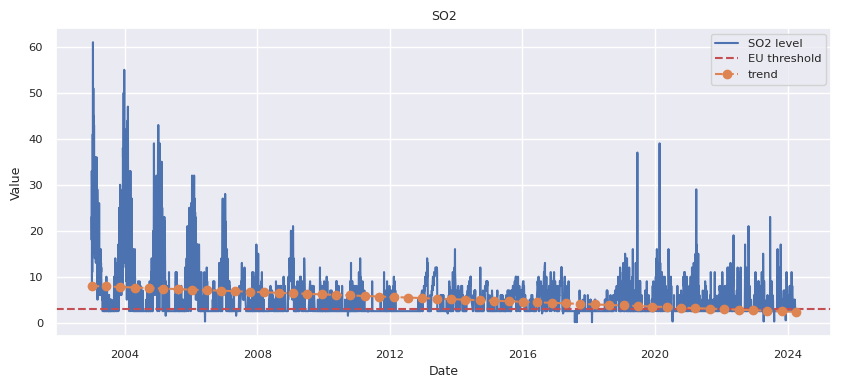

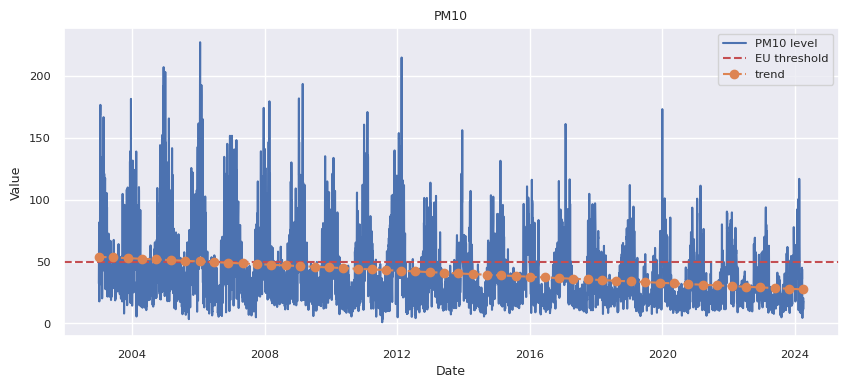

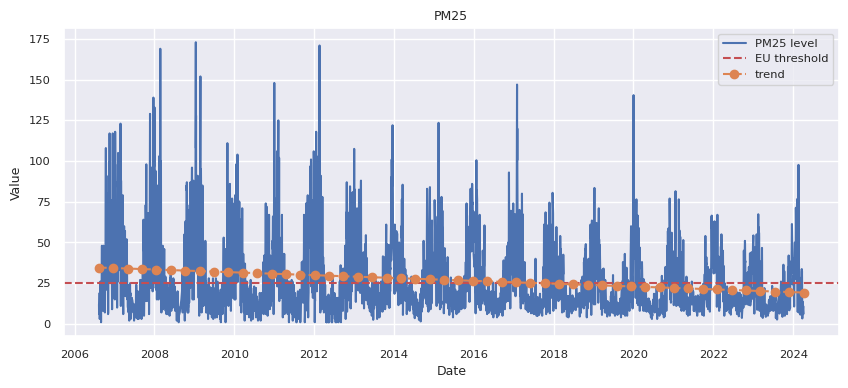

In [11]:
import matplotlib.dates as md

df_date = df.set_index(['data','inquinante'])
sns.set_theme(rc={'figure.figsize':(10,4)})
sns.set(font_scale=0.75)
for i, pa in enumerate(pollution_agents):
    plt.title(pa)
    df_agg = df_date[df_date.index.get_level_values(1)==pa].groupby(['data','inquinante'])['valore'].mean().reset_index(name ='valore')
    df_agg = df_agg.set_index('data')
    
    x_dates = df_agg.index.get_level_values(0)
    x_num = md.date2num(df_agg.index.get_level_values(0))
    trend = np.polyfit(x_num, df_agg.valore, 1)
    fit = np.poly1d(trend)
    
    plt.plot(df_agg.index.get_level_values(0), df_agg.valore, label=f'{pa} level')
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    x_fit = np.linspace(x_num.min(), x_num.max())
    plt.axhline(y = agent_eu_limits[pa], color = 'r', linestyle = '--', label='EU threshold') 
    plt.plot(md.num2date(x_fit), fit(x_fit), "o--", label='trend')
    plt.legend()
    plt.show()

# Pollution agents on monthly basis (aggregated by all years)

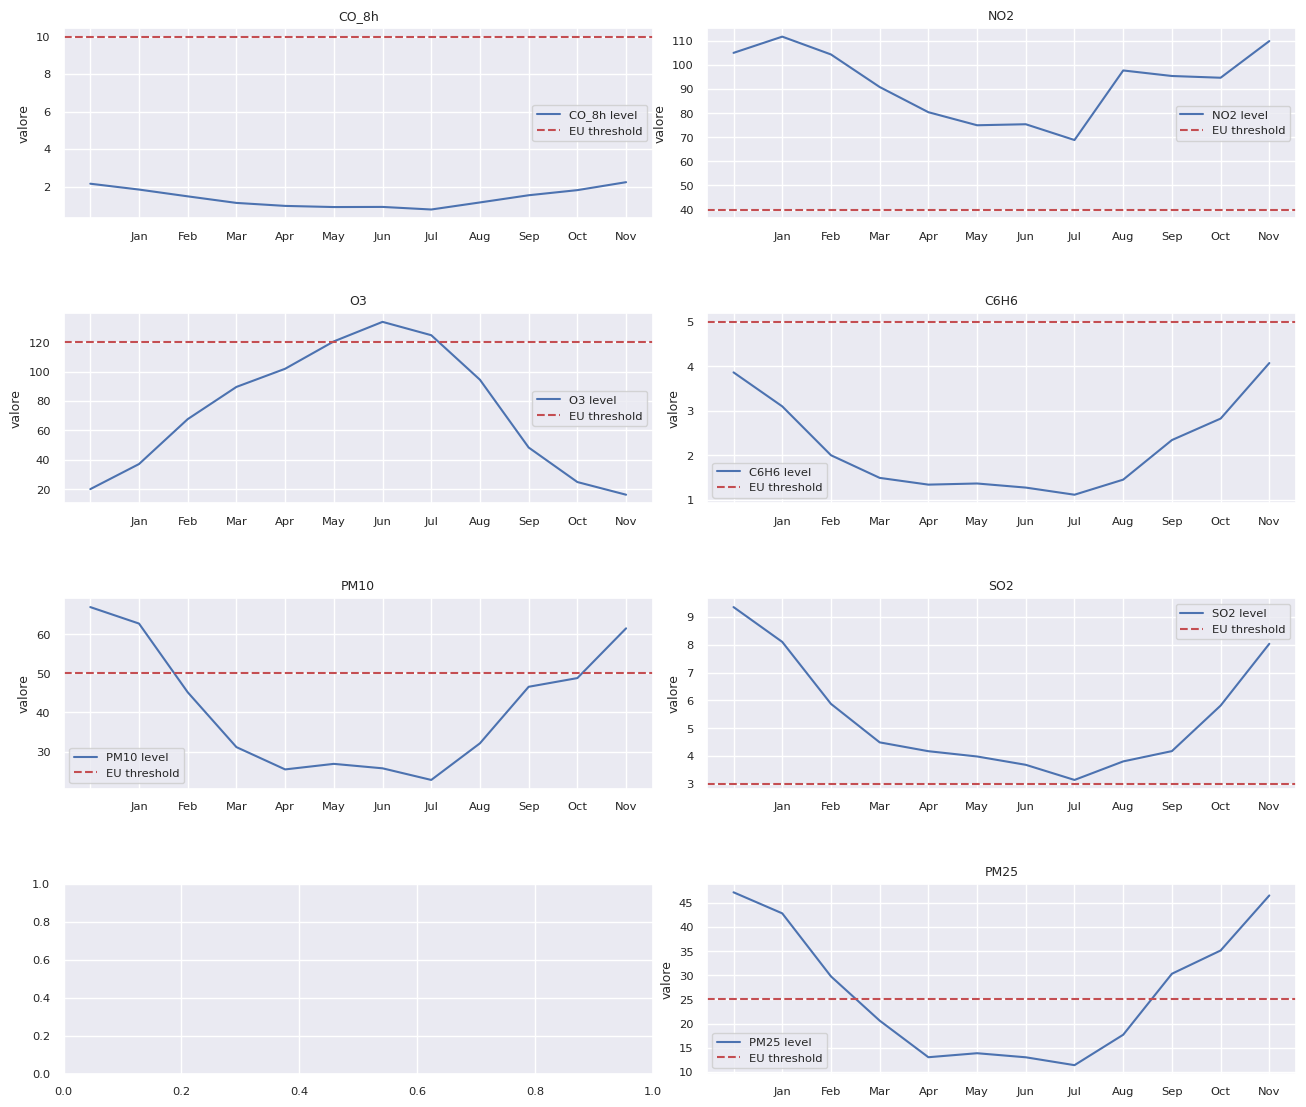

In [12]:
import calendar

df_indexed_month = df
df_indexed_month['month'] = df_indexed_month["data"].dt.month
df_indexed_month = df_indexed_month.set_index(['month'])
f,ax=plt.subplots(4,2,figsize=(13,11))
f.tight_layout()
f.subplots_adjust(hspace=0.5)
sns.set(font_scale=0.75)

for i,pa in enumerate(pollution_agents):
    row = int(i/2)
    col = int(i%2==0)
    plt.title(pa)
    df_indexed_month_pa = df_indexed_month[df_indexed_month['inquinante']==pa].groupby(['month','inquinante'])['valore'].mean().reset_index(name ='valore')
    df_indexed_month_pa.index = df_indexed_month_pa.index.map(lambda x: f'{calendar.month_abbr[x]}')
    sns.lineplot(data=df_indexed_month_pa, x=df_indexed_month_pa.index.get_level_values(0), y=df_indexed_month_pa.valore, ax=ax[row,col], label=f'{pa} level')
    th=ax[row,col].axhline(y = agent_eu_limits[pa], color = 'r', linestyle = '--', label='EU threshold')
    th.set_label('EU threshold')
    ax[row,col].legend(loc='best')
    ax[row,col].set_title(pa)

# Pollution agent levels for month and year (heatmaps)

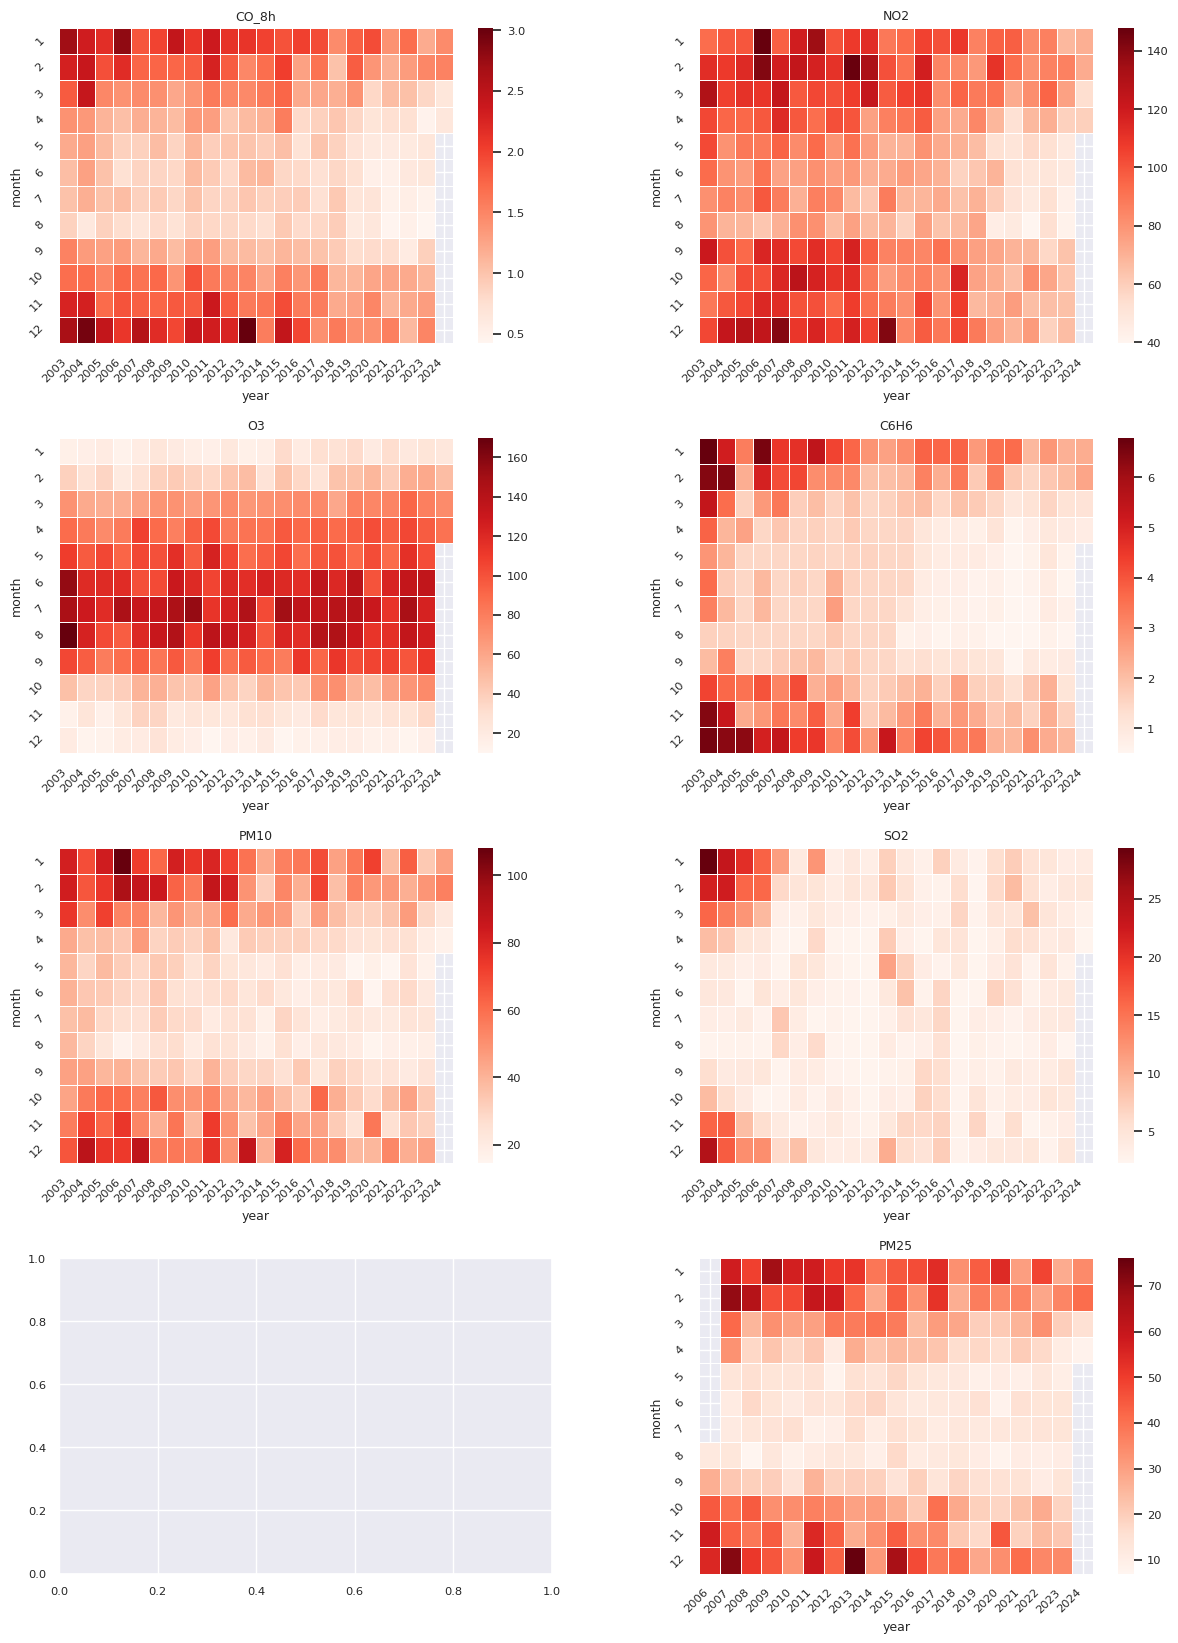

In [13]:
import calendar
df_indexed_month_year = df[['data','inquinante','valore']]
df_indexed_month_year['month'] = df_indexed_month_year["data"].dt.month
df_indexed_month_year['year'] = df_indexed_month_year["data"].dt.year
df_indexed_month_year = df_indexed_month_year.set_index(['month'])
f,ax=plt.subplots(4,2,figsize=(12,16))
f.tight_layout()
f.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(font_scale=0.75)

for i,pa in enumerate(pollution_agents):
    row = int(i/2)
    col = int(i%2==0)
    plt.title(pa)
    df_indexed_month_year_pa = df_indexed_month_year[df_indexed_month_year['inquinante']==pa].groupby(['month','year'])['valore'].mean().reset_index(name ='valore')
    sns.heatmap(df_indexed_month_year_pa.pivot(index='month', columns="year", values="valore"), linewidth=.5, ax=ax[row,col], cmap="Reds")
    ax[row,col].set_title(pa)
    #ax[row,col].set_yticklabels(df_indexed_month_year_pa['month'].map(lambda x: f'{calendar.month_abbr[x]}'))
    ax[row,col].set_yticklabels(ax[row,col].get_yticklabels(), rotation=45, horizontalalignment='right');
    ax[row,col].set_xticklabels(ax[row,col].get_xticklabels(), rotation=45, horizontalalignment='right');

# Yearly pollution trend 

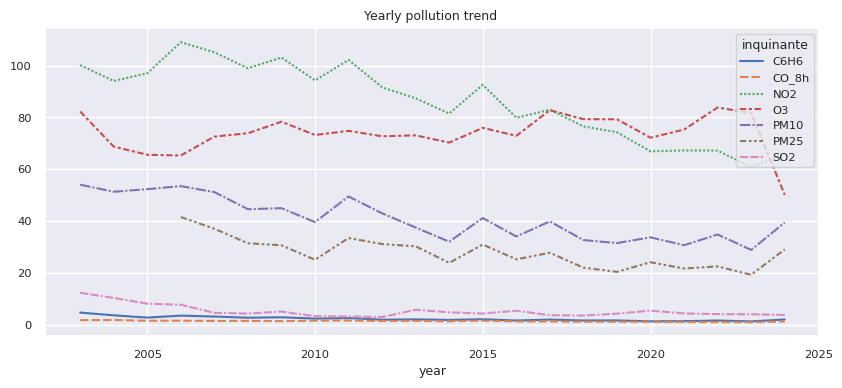

In [14]:
df_trend = df
df_trend['year'] = df["data"].dt.year
df_trend = df_trend.drop(['data','stazione_id','month'], axis=1)
df_trend = df_trend.groupby(['year','inquinante'])['valore'].mean().reset_index(name ='valore')
df_trend = df_trend.set_index(['year'])
df_trend_pivot = df_trend.pivot(columns="inquinante", values="valore")
lp = sns.lineplot(data=df_trend_pivot).set_title('Yearly pollution trend ')